<a href="https://colab.research.google.com/github/igorcduarte/Transfer-Learning-ML/blob/main/Projeto_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import zipfile
import os

In [ ]:
# Baixar o dataset
!wget -O cats_and_dogs.zip "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"

# Extrair o dataset
with zipfile.ZipFile("cats_and_dogs.zip", 'r') as zip_ref:
    zip_ref.extractall("cats_and_dogs")

# Caminho para o dataset extraído
dataset_dir = "cats_and_dogs/PetImages"

--2024-12-21 18:31:59--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.192.208.155, 2600:1409:12:299::317f, 2600:1409:12:2b7::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.192.208.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘cats_and_dogs.zip’

cats_and_dogs.zip   100%[===================>] 786.67M  76.5MB/s    in 9.6s    

2024-12-21 18:32:08 (81.8 MB/s) - ‘cats_and_dogs.zip’ saved [824887076/824887076]



In [ ]:
import shutil
from sklearn.model_selection import train_test_split

# Criar pastas de treino e validação
base_dir = 'cats_and_dogs_dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

for label in ['Cat', 'Dog']:
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(val_dir, label), exist_ok=True)

# Organizar imagens
for label in ['Cat', 'Dog']:
    label_dir = os.path.join(dataset_dir, label)
    images = os.listdir(label_dir)

    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

    for img in train_images:
        shutil.move(os.path.join(label_dir, img), os.path.join(train_dir, label))

    for img in val_images:
        shutil.move(os.path.join(label_dir, img), os.path.join(val_dir, label))

In [ ]:
# Carregar modelo pre-treinado
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from PIL import Image

def remove_corrupted_images(directory):
    num_removed = 0
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Verifica a integridade da imagem
            except (IOError, SyntaxError):
                print(f"Removendo imagem corrompida: {file_path}")
                os.remove(file_path)
                num_removed += 1
    print(f"{num_removed} imagens corrompidas removidas.")

# Verificar o dataset
remove_corrupted_images(train_dir)
remove_corrupted_images(val_dir)

0 imagens corrompidas removidas.
Removendo imagem corrompida: cats_and_dogs_dataset/validation/Dog/Thumbs.db
Removendo imagem corrompida: cats_and_dogs_dataset/validation/Dog/11702.jpg
Removendo imagem corrompida: cats_and_dogs_dataset/validation/Cat/666.jpg
Removendo imagem corrompida: cats_and_dogs_dataset/validation/Cat/Thumbs.db
4 imagens corrompidas removidas.


In [ ]:
# Preparar os dados
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


In [ ]:
# Compilar e treinar o modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1212s 2s/step - accuracy: 0.9693 - loss: 0.0769 - val_accuracy: 0.9854 - val_loss: 0.0414
Epoch 2/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0251
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1264s 2s/step - accuracy: 0.9738 - loss: 0.0639 - val_accuracy: 0.9806 - val_loss: 0.0502
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0188
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1224s 2s/step - accuracy: 0.9728 - loss: 0.0644 - val_accuracy: 0.9842 - val_loss: 0.0413
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0210
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1246s 2s/step - accuracy: 0.9794 - loss: 0.0492 - val_accuracy: 0.9846 - val_loss: 0.0410
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0086
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1220s 2s/step - accuracy: 0.97

In [ ]:
# Fine-Tuning
base_model.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=5
)


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 4076s 6s/step - accuracy: 0.9215 - loss: 0.1984 - val_accuracy: 0.9818 - val_loss: 0.0492
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0703
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 4103s 6s/step - accuracy: 0.9669 - loss: 0.0813 - val_accuracy: 0.9866 - val_loss: 0.0375
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 9.0785e-04
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 4104s 7s/step - accuracy: 0.9773 - loss: 0.0585 - val_accuracy: 0.9872 - val_loss: 0.0357


In [ ]:
# Salvar modelo
model.save('cats_and_dogs_model.h5')

In [ ]:
from tensorflow.keras.models import load_model

# Carregar o modelo salvo
model = load_model('cats_and_dogs_model.h5')

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Fazer o upload de uma imagem
uploaded = files.upload()

for file_name in uploaded.keys():
    # Carregar e pré-processar a imagem
    img_path = file_name
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0  # Normalizar
    img_array = np.expand_dims(img_array, axis=0)  # Adicionar dimensão para batch

Saving cat.jpg to cat.jpg


In [ ]:
# Fazer a predição
predictions = model.predict(img_array)

# Interpretar os resultados
class_names = ['Cat', 'Dog']  # Labels correspondentes
predicted_class = class_names[np.argmax(predictions)]
confidence = np.max(predictions)

print(f"Classe prevista: {predicted_class}")
print(f"Confiança: {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
Classe prevista: Cat
Confiança: 1.00


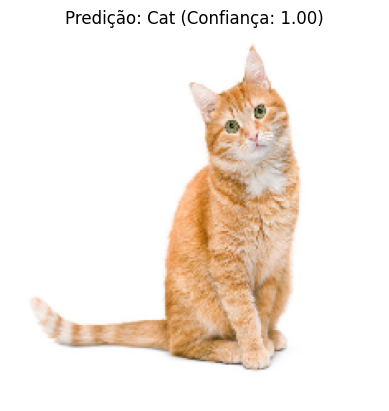

In [ ]:
import matplotlib.pyplot as plt

# Mostrar a imagem com a predição
plt.imshow(img)
plt.title(f"Predição: {predicted_class} (Confiança: {confidence:.2f})")
plt.axis('off')
plt.show()

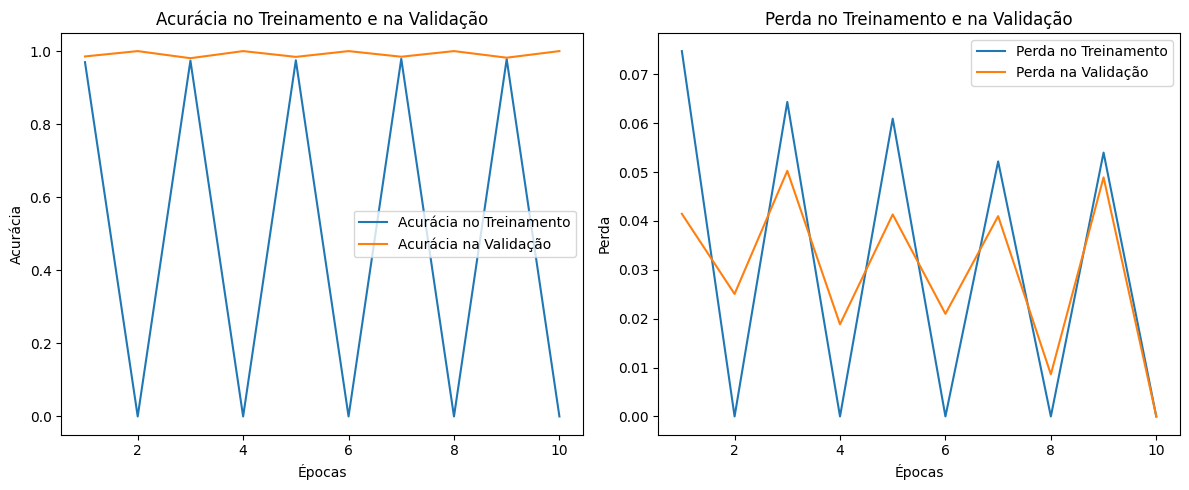

In [ ]:
import matplotlib.pyplot as plt

# Função para plotar os gráficos
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Gráfico de Acurácia
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Acurácia no Treinamento')
    plt.plot(epochs, val_acc, label='Acurácia na Validação')
    plt.title('Acurácia no Treinamento e na Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()

    # Gráfico de Perda
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Perda no Treinamento')
    plt.plot(epochs, val_loss, label='Perda na Validação')
    plt.title('Perda no Treinamento e na Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Chamar a função com o histórico do treinamento
plot_training_history(history)